In [1]:
import numpy as np
import sys
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

%matplotlib inline
import glob
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
import importlib

import math
import geopy
from geopy import distance

In [2]:
#download the ECCO grid file

from ecco_download import *

ecco_podaac_download(ShortName="ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                    StartDate="2000-01-01",EndDate="2000-12-31",download_root_dir=None,\
                    n_workers=6,force_redownload=False)

created download directory /home/m267zhou/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4
{'ShortName': 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4', 'temporal': '2000-01-01,2000-12-31'}

Total number of matching granules: 1

GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading
DL Progress: 100%|########################| 1/1 [00:00<00:00, 19152.07it/s]

total downloaded: 0.0 Mb
avg download speed: 0.0 Mb/s


In [3]:
# download file (granule) containing 2000 velocities,
# to default path ~/Downloads/ECCO_V4r4_PODAAC/
vol_monthly_shortname = "ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4"
ecco_podaac_download(ShortName=vol_monthly_shortname,\
                    StartDate="2000-01-01",EndDate="2000-12-31",download_root_dir=None,\
                    n_workers=6,force_redownload=False)

created download directory /home/m267zhou/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4
{'ShortName': 'ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2000-01-01,2000-12-31'}

Total number of matching granules: 13

OCEAN_3D_VOLUME_FLUX_mon_mean_1999-12_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_3D_VOLUME_FLUX_mon_mean_2000-01_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_3D_VOLUME_FLUX_mon_mean_2000-03_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_3D_VOLUME_FLUX_mon_mean_2000-04_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_3D_VOLUME_FLUX_mon_mean_2000-05_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_3D_VOLUME_FLUX_mon_mean_2000-06_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_3D_VOLUME

In [4]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

from os.path import join,expanduser
user_home_dir = expanduser('~')

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

In [5]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

In [6]:
## Load the model grid
ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])

In [7]:
## Load vector fields
ecco_vars1 = xr.open_mfdataset(join(ECCO_dir,'*OCEAN*VEL*MONTHLY*','*_2000-*.nc'))
ecco_vars2 = xr.open_mfdataset(join(ECCO_dir,'*OCEAN*VOLUME*MONTHLY*','*_2000-*.nc'))


ecco_ds = []

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_ds = xr.merge((ecco_grid , ecco_vars1, ecco_vars2)).load()

In [8]:
#To store complete zonal integral in 2D arrays (integrate over all longitudes). Dimension is depth by lat.
complete_zonal_integral_for_VVELMASS = np.zeros((50, 52+90))

In [9]:
#Exclude pacific ocean
xfld = ecco_ds.UVEL.isel(k=0, time=0)
yfld = ecco_ds.VVEL.isel(k=0, time=0)
#Compute the zonal and meridional vector components of UVEL and VVEL
VEL_E, VEL_N  = ecco.vector_calc.UEVNfromUXVY(xfld, yfld, ecco_ds)
valid_lon_for_each_lat = np.zeros(90)
for lat in range(0,90):
    for lon in range(0,90):
        if (math.isnan(VEL_E.isel(tile=10)[lon,lat]) == True):
            valid_lon_for_each_lat[lat] = lon
            break
        else:
            continue

In [10]:
#Compute zonal integral of meridional velocity (VVELMASS)
#the Atlantic ocean is in tile 1,2,10,11
for depth in range(0,50):
    xfld = ecco_ds.UVELMASS.isel(k=depth, time=0)
    yfld = ecco_ds.VVELMASS.isel(k=depth, time=0)
    
    # Compute the zonal and meridional vector components of UVEL and VVEL
    VEL_E, VEL_N  = ecco.vector_calc.UEVNfromUXVY(xfld, yfld, ecco_ds)  
    
    for lat in range(0,90):
        sum = 0
        for lon in range(0,89):
            if ((math.isnan(VEL_N.isel(tile=10)[lon,lat]) == True) or (valid_lon_for_each_lat[lat] >= lon)):
                sum = sum
            else:
                sum = sum + VEL_N.isel(tile=10)[lon,lat] * distance.distance((VEL_N.isel(tile=10).YC[lon,lat], VEL_N.isel(tile=10).XC[lon,lat]), (VEL_N.isel(tile=10).YC[lon+1,lat], VEL_N.isel(tile=10).XC[lon+1,lat])).m
        for lon in range(0,89):
            if (math.isnan(VEL_N.isel(tile=2)[89-lat, lon]) == True):
                sum = sum
            else:
                sum = sum + VEL_N.isel(tile=2)[89-lat, lon] * distance.distance((VEL_N.isel(tile=2).YC[89-lat, lon], VEL_N.isel(tile=2).XC[89-lat, lon]), (VEL_N.isel(tile=2).YC[89-lat, lon+1], VEL_N.isel(tile=2).XC[89-lat, lon+1])).m
        
        complete_zonal_integral_for_VVELMASS[depth, lat] = sum
        
    for lat in range(0,52):
        sum = 0
        for lon in range(67,89):
            if (math.isnan(VEL_N.isel(tile=11)[lon,lat]) == True):
                sum = sum
            else:
                sum = sum + VEL_N.isel(tile=11)[lon,lat] * distance.distance((VEL_N.isel(tile=11).YC[lon,lat], VEL_N.isel(tile=11).XC[lon,lat]), (VEL_N.isel(tile=11).YC[lon+1,lat], VEL_N.isel(tile=11).XC[lon+1,lat])).m
        for lon in range(0,57):
            if (math.isnan(VEL_N.isel(tile=1)[89-lat, lon]) == True):
                sum = sum
            else:
                sum = sum + VEL_N.isel(tile=1)[89-lat, lon] * distance.distance((VEL_N.isel(tile=1).YC[89-lat, lon], VEL_N.isel(tile=1).XC[89-lat, lon]), (VEL_N.isel(tile=1).YC[89-lat, lon+1], VEL_N.isel(tile=1).XC[89-lat, lon+1])).m
        
        complete_zonal_integral_for_VVELMASS[depth, 89+lat] = sum
        

In [11]:
xfld = ecco_ds.UVEL.isel(k=0, time=0)
yfld = ecco_ds.VVEL.isel(k=0, time=0)
# Compute the zonal and meridional vector components of UVEL and VVEL
VEL_E, VEL_N  = ecco.vector_calc.UEVNfromUXVY(xfld, yfld, ecco_ds)  

# Get latitude and depth array
latitude_array = np.append(VEL_N.isel(tile=10).YC[0,:].values, VEL_N.isel(tile=11).YC[0,0:52].values)
depth_array = ecco_grid.Z[0:50].values

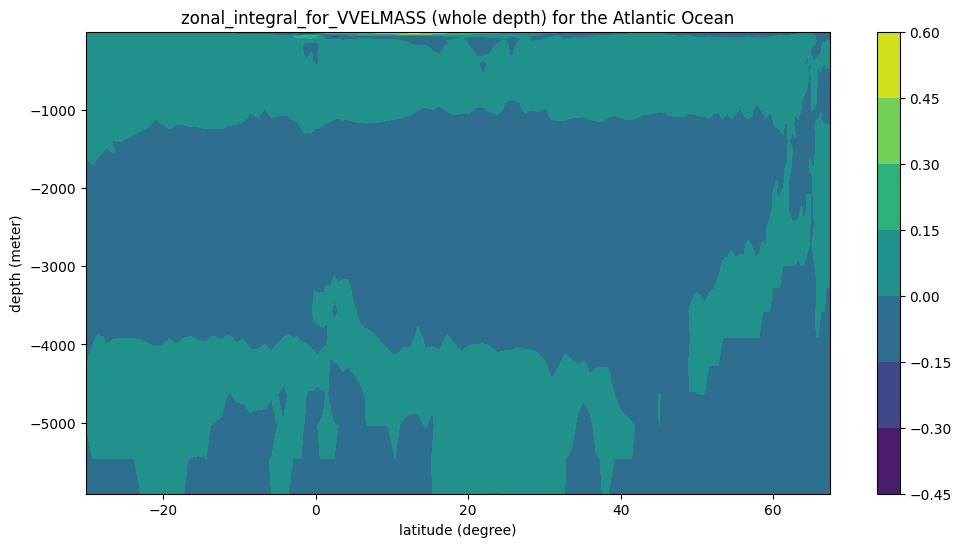

In [12]:
# Plot
plt.figure(figsize=(12,6))
plt.contourf(latitude_array, depth_array, complete_zonal_integral_for_VVELMASS/1000000)
plt.title('zonal_integral_for_VVELMASS (whole depth) for the Atlantic Ocean')
plt.xlabel('latitude (degree)')
plt.ylabel('depth (meter)')
plt.colorbar()